In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.fl_model_v10 import *
import pygmo as pg
import seaborn as sns

# Notes

Ending note: It could be that over time, hypervolumes donnot increase. It's "unfair" to compare hypervolumes over different periods. This is because cost will increase over time, while the others will decrease over time.


#  Code

In [2]:
case = "Nepal"
output_folder = "Simulation-results"

In [3]:
# Load data (deserialize)
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [4]:
def find_nodes_next_step(node,label_tree):
    # Find which period
    for i,l in enumerate(reversed(node)):
        if l == 'p':
            period = int((list(reversed(node))[i-1]))
            break
    # Find next period
    labels_next_p = label_tree["p{}".format(period+1)]
#     print(labels_next_p)
    return [l for l in labels_next_p if node in l]

find_nodes_next_step('p0n0p1n2', global_label_tree)

['p0n0p1n2p2n15', 'p0n0p1n2p2n16', 'p0n0p1n2p2n17', 'p0n0p1n2p2n18']

In [5]:
def get_mordm_resulting_policies(node, label_tree, policy_tree):
    # Get all labels of resulting mordm cycle
    labels = find_nodes_next_step(node,label_tree)
    # Get all policies for these labels
    policies = [policy_tree[label] for label in labels] 
    return policies

# get_mordm_resulting_policies("p0n0", global_label_tree, global_policy_tree)

In [6]:
def get_all_mordms_in_period(period, label_tree, policy_tree):
    nodes = label_tree[period]
    mordm_results = [get_mordm_resulting_policies(node,label_tree,policy_tree) for node in nodes]
    return mordm_results

# get_all_mordms_in_period("p1",global_label_tree,global_policy_tree)

In [7]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)
# Fix_Unc

In [8]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}

In [9]:
epicentre_name = "RealLocation"
disruptionsFLs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionFL{}.txt'.format(case,epicentre_name))
disruptionsDPs = np.loadtxt(
    '{}/Prepared Input Data/DisruptionDP{}.txt'.format(case,epicentre_name))

# DSRDP = {"DSRDP{}".format(i): 1.5 for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): 1.5 for i in range(len(FLX))}

In [10]:
DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

In [11]:
def evaluate_pol_set(pol_set):
    results = []
    for policy in pol_set:
        results.append(FL_model(
#             unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
#             FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))
    return results

In [12]:
def get_branch_performance(period, label_tree, policy_tree):
    p_mordm_pol_sets = get_all_mordms_in_period(period, label_tree,
                                                policy_tree)
    result_sets = []
    for pol_set in p_mordm_pol_sets:
        result_sets.append(evaluate_pol_set(pol_set))
    return result_sets

In [13]:
def get_uncertainty_bandwiths(period,
                              label_tree,
                              var_unc_data,
                              function="mean"):
    """
    period: string: E.g. "p0"
    function: string. function to perform on pandas Series.
        E.g.: mean, max, min
    """
    p_labels = label_tree[period]
    bandwidth_metrics = []
    for l in p_labels:
        bandwith = (var_unc_data[l].upper - var_unc_data[l].lower)
        metric = eval("bandwith.{}()".format(function))
#         print(l)
#         print(bandwith)
        bandwidth_metrics.append(metric)
    return bandwidth_metrics

# Correlate hypervolumes and uncertainties

Check if policies always in same order. Otherwise, not the right points connected to each other.

if so. Then Get best estimate objective evaluations

In [14]:
a = get_branch_performance('p3', global_label_tree,
                                  global_policy_tree)
# b = normalise_sets(a)

# c = compute_hypervolumes(sets_normalised)

# d = get_uncertainty_bandwiths('p4', global_label_tree,
#                                     global_dfs_var_unc_data)

In [18]:
len(a)

231

In [16]:
len(global_label_tree['p3'])

231

In [19]:
global_label_tree['p3'][0]

'p0n0p1n1p2n7p3n45'

In [20]:
def find_previous_label(label):
    for i,l in enumerate(label[::-1]):
        if l == "p":
            return label[:-i-1]
#test
# find_previous_label(label0)

In [21]:
def policy_to_fls(pol):
    return [int(key[3:]) for key, val in pol.items() if val == 1]

In [22]:
def find_previous_performance(label, objective=None):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            if objective == None:
                return prev_perf.loc[fl]
            else:
                return prev_perf.loc[fl][objective]
    raise ValueError("Something went wrong")

In [23]:
def find_label_at_p(label, p='p1'):
    for i,l in enumerate(label):
        if p in label[i:i+2]:
            last_p_i = i
    remaining = label[last_p_i+1:]
    for i,l in enumerate(remaining):
        if l == 'p':
            return label[:i+last_p_i+1]

find_label_at_p('p0n0p1n7p2n50p3n307')

'p0n0p1n7'

In [24]:
def find_last_fl(label):
    prev_label = find_previous_label(label)
    prev_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, prev_label), index_col=0)
    cur_pol = global_policy_tree[label]
    cur_fls = policy_to_fls(cur_pol)
    for fl in cur_fls:
        if fl in prev_perf.index:
            return fl, prev_label
    raise ValueError("Something went wrong")

find_last_fl("p0n0p1n1p2n8p3n53")

(7, 'p0n0p1n1p2n8')

In [25]:
def find_fl_placement_sequence(label):
    """verificated"""
    max_ps = label.count("p")-1
    sequence = []
    cur_label = label
    while len(sequence) < max_ps:
        last_fl, prev_label = find_last_fl(cur_label)
        sequence.append(last_fl)
        cur_label = prev_label
    return list(reversed(sequence))
    
    

In [26]:
def find_originating_performance(label, objective=None, period='p0'):
    """Verificated"""
    orig_label = find_label_at_p(label, period)
    orig_perf = pd.read_csv("{}/{}/nondom_BE_pols{}.csv".format(case, output_folder, orig_label), index_col=0)
    period_i = int(period[1])
    
    fl_sequence = find_fl_placement_sequence(label)
    fl = fl_sequence[period_i]
#     print(fl,orig_label)
    if objective == None:
        return orig_perf.loc[fl]
    else:
        return orig_perf.loc[fl][objective]
    raise ValueError("Something went wrong")

In [27]:
p4labels=global_label_tree['p4']

In [28]:
len(p4labels)

1152

Note:
- Take Both performance as uncertainty at p4
- performance at p4 can be retrieved from mordm optimisation at p3
- Why this and not over real values? Because we look at objective prioritisations (subjective), not at the real performance(objective).

In [29]:
uncertainty_bandwidths_p4 = get_uncertainty_bandwiths("p4", global_label_tree, global_dfs_var_unc_data, function="mean")

In [30]:
len(uncertainty_bandwidths_p4)

1152

In [31]:
df1 = pd.DataFrame([uncertainty_bandwidths_p4,p4labels]).T
df1.head()

,0,1
0,0.0968261,p0n0p1n1p2n7p3n45p4n276
1,0.0986506,p0n0p1n1p2n7p3n45p4n277
2,0.130896,p0n0p1n1p2n7p3n45p4n278
3,0.142235,p0n0p1n1p2n7p3n45p4n279
4,0.143645,p0n0p1n1p2n7p3n45p4n280


In [32]:
p3_performances = df1.apply(
    lambda row: find_originating_performance(row[1], period='p3'), axis=1)

In [33]:
p3_performance_unc_range = pd.concat([df1,p3_performances], axis=1)

p3_performance_unc_range.columns = [
    'uncertainty', 'label', 'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]

p3_performance_unc_range = p3_performance_unc_range.set_index('label')
p3_performance_unc_range = p3_performance_unc_range.astype(float)
p3_performance_unc_range.head()

,uncertainty,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
label,,,,,
p0n0p1n1p2n7p3n45p4n276,0.096826,8.716823e+05,13.0,2944.656956,57150.213923
p0n0p1n1p2n7p3n45p4n277,0.098651,1.015160e+06,10.0,1758.413852,57150.213923
p0n0p1n1p2n7p3n45p4n278,0.130896,4.215562e+05,17.0,5077.406180,57150.213923
p0n0p1n1p2n7p3n45p4n279,0.142235,3.486746e+05,19.0,6151.009065,57150.213923
p0n0p1n1p2n7p3n45p4n280,0.143645,3.859724e+05,18.0,5737.300119,57150.213923


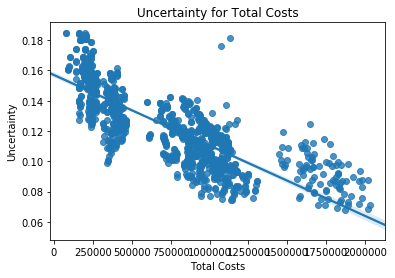

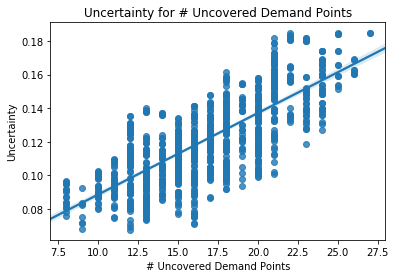

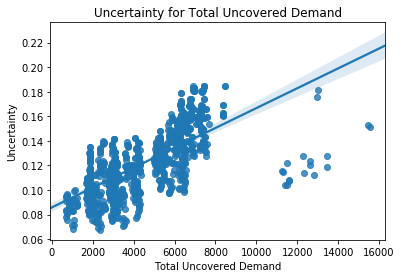

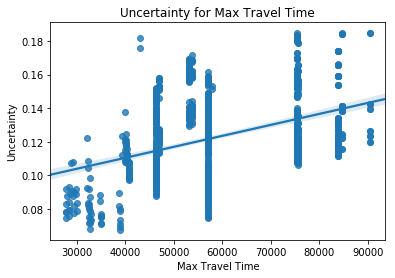

In [35]:
objectives = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_distr_time'
]
objectives_nice = [
    'Total Costs', '# Uncovered Demand Points', 'Total Uncovered Demand',
    'Max Travel Time'
]
for obj, obj_nice in zip(objectives, objectives_nice):
    ax = sns.regplot(
        y=p3_performance_unc_range['uncertainty'],
        x=p3_performance_unc_range[obj],
        fit_reg=True)
    ax.set(title = "Uncertainty for {}".format(obj_nice),
           xlabel = obj_nice,
           ylabel = "Uncertainty"
          )

    plt.savefig(
        "{}/Analysis/Uncertainty for {}".format(case,
                                                   obj_nice),
        dpi=500,
        bbox_inches='tight')
    plt.show()

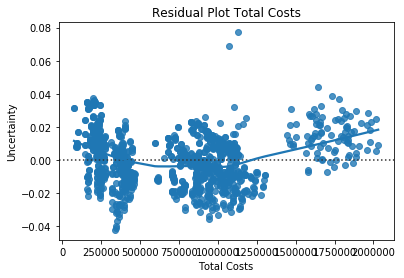

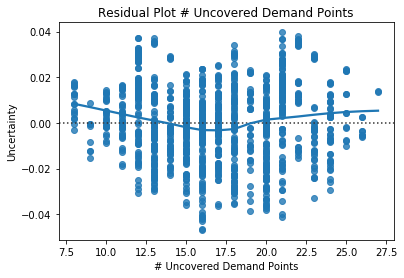

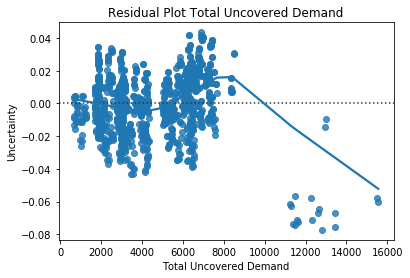

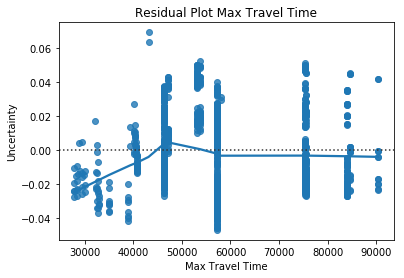

In [36]:
for obj, obj_nice in zip(objectives, objectives_nice):
    ax = sns.residplot(
        y=p3_performance_unc_range['uncertainty'],
        x=p3_performance_unc_range[obj], lowess=True)
#     plt.show()
    ax.set(title = "Residual Plot {}".format(obj_nice),
           xlabel = obj_nice,
           ylabel = "Uncertainty"
          )

    plt.savefig(
        "{}/Analysis/Residual Plot {}".format(case,
                                                   obj_nice),
        dpi=500,
        bbox_inches='tight')
    plt.show()

## Regression analysis

In [37]:
from scipy import stats
y = np.array(p3_performance_unc_range['uncertainty']).astype(float)
total_cost = np.array(p3_performance_unc_range['total_costs']).astype(float)

In [38]:
for obj in objectives:
    y = np.array(p3_performance_unc_range['uncertainty']).astype(float)
    x = np.array(p3_performance_unc_range[obj]).astype(float)
    print(obj, ":")
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print("slope:", slope, '\nintercept:', intercept, '\nr2:', r_value**2,
          '\np_value:', p_value, '\nstd_err:', std_err)
    print("")

total_costs :
slope: -4.6566238864563536e-08 
intercept: 0.15704727283707162 
r2: 0.6475516955442026 
p_value: 1.1105146516499417e-262 
std_err: 1.013054317438915e-09

nr_uncovered_DPs :
slope: 0.004857352979128381 
intercept: 0.03998498856992992 
r2: 0.5779195694625001 
p_value: 1.2374789651029377e-217 
std_err: 0.00012240936703516328

total_uncovered_demand :
slope: 8.077504577472494e-06 
intercept: 0.08590194524848752 
r2: 0.4717875281558565 
p_value: 1.409863080207475e-161 
std_err: 2.520341498178986e-07

max_distr_time :
slope: 6.535007930649198e-07 
intercept: 0.08434179370095582 
r2: 0.138604018007804 
p_value: 3.466814219992489e-39 
std_err: 4.804085294062943e-08



## Multiple Regression

In [39]:
import statsmodels.api as sm

C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\timro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
x = p3_performance_unc_range[objectives]
y = p3_performance_unc_range['uncertainty']
x = sm.add_constant(x)


In [41]:
model = sm.OLS(y,x).fit()

In [42]:
predictions = model.predict(x)

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            uncertainty   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1025.
Date:                Tue, 31 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:57:49   Log-Likelihood:                 3454.9
No. Observations:                1152   AIC:                            -6900.
Df Residuals:                    1147   BIC:                            -6875.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0742      0.004     19.770      0.000       0.067       0.082
total_costs            -2.577e-08   1.34e-09    -19.277      0.000   -2.84e-08   -2.31e-08
nr_uncovered_DPs           0.0014      0.000      6.535      0.000       0.001       0.002
total_uncovered_demand  2.296e-06   3.74e-07      6.141      0.000    1.56e-06    3.03e-06
max_distr_time          5.693e-07   2.59e-08     21.970      0.000    5.19e-07     6.2e-07
==============================================================================
Omnibus:                        3.523   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.495
Skew:                           0.135   Prob(JB):                        0.174
Kurtosis:                       3.002   Cond. No.                     9.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
model.rsquared

0.7813174839508195

In [45]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.781     
Dependent Variable:   uncertainty       AIC:                 -6899.7970
Date:                 2018-07-31 10:57  BIC:                 -6874.5507
No. Observations:     1152              Log-Likelihood:      3454.9    
Df Model:             4                 F-statistic:         1025.     
Df Residuals:         1147              Prob (F-statistic):  0.00      
R-squared:            0.781             Scale:               0.00014604
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
const                   0.0742   0.0038  19.7705 0.0000  0.0669  0.0816
total_costs            -0.0000   0.0000 -19.2772 0.0000 -0.0000 -0.0000
nr_uncovered_DPs        0.0014   0.0002   6.5354 0.0000  0.0010  0.0018
total_uncovered_demand  0.0000   0.0000   6.1406 0.0000  0.0000  0.0000
max_distr_time          0.0000   0.0000  21.9704 0.0000  0.0000  0.0000
-----------------------------------------------------------------------
Omnibus:                3.523         Durbin-Watson:            1.173  
Prob(Omnibus):          0.172         Jarque-Bera (JB):         3.495  
Skew:                   0.135         Prob(JB):                 0.174  
Kurtosis:               3.002         Condition No.:            9200381
=======================================================================
* The condition number is large (9e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [46]:
p3_performance_unc_range.shape[0]

1152